In [1]:
!uv pip install geopandas pandas pyarrow matplotlib shapely
import geopandas as gpd
import math
import shapely
import pandas as pd

Audited 5 packages in 19ms


In [2]:
filename = "02-55-5505-090_1.UG.parquet"

df = gpd.read_parquet(filename)
df["level"] = df["level"].astype("category")
df["type"] = df["type"].astype("category")

# the current extraction logic is a bit messy with this => lets split for better analysis
# df["super_type"] = df["name"].map(lambda s: s.split(" | ")[0])
# df["sub_type_id"] = df["name"].map(lambda s: int(s.split("(")[1].strip(")")))
# df["sub_type"] = df["name"].map(lambda s: s.split("(")[0].split(" | ")[1]).astype("category")
# df = df.rename(columns={"height": "height_geom"})  # todo: remove once reprocessed
# df.drop("name", inplace=True, axis=1)
# df

In [3]:
# the generated metadata is pretty messy => lets clean it up before further looking at it
def fix_metadata(d: dict) -> dict:
    result = {}
    if not d:  # can also be None
        d = {}
    for k, v in d.items():
        if k == "None":
            for k2, v2 in fix_metadata(v).items():
                result[k2] = v2
        elif isinstance(v, dict):
            for k2, v2 in fix_metadata(v).items():
                result[k + "." + k2] = v2
        elif v is None or v.strip() in ["None", "-", "-_-", "-_", "_-", ""]:  # why though?
            result[k] = None
        elif v.strip() in ["True", "False"]:
            result[k] = bool(v)
        else:
            result[k] = v.strip()  # valid string
    return result


df["metadata"] = df["metadata"].map(fix_metadata)

In [4]:
df

,name,metadata,height,geometry,type,level
0,DOOR | Drehflügel 1-flg.(1),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",2.20,"POLYGON ((76533.617 77349.607, 76533.603 77349...",door,0
1,DOOR | Drehflügel 1-flg.(2),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",2.20,"POLYGON ((76526.211 77349.755, 76526.225 77350...",door,0
2,DOOR | Drehflügel 1-flg.(3),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",2.20,"POLYGON ((76532.692 77359.804, 76532.607 77359...",door,0
3,DOOR | Drehflügel 1-flg.(4),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",1.80,"POLYGON ((76535.948 77360.628, 76535.903 77360...",door,0
4,DOOR | Drehflügel 1-flg.(5),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",1.80,"POLYGON ((76542.755 77358.285, 76542.709 77358...",door,0
...,...,...,...,...,...,...
414,OPENING#,"{'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...",NaN,"POLYGON ((76576.281 77337.36, 76576.203 77337....",opening,0
415,OPENING(4),"{'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...",NaN,"POLYGON ((76622.547 77337.775, 76622.584 77337...",opening,0
416,OPENING(5),"{'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...",NaN,"POLYGON ((76602.029 77344.226, 76601.972 77344...",opening,0
417,OPENING(6),"{'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...",NaN,"POLYGON ((76600.825 77340.727, 76600.768 77340...",opening,0


In [5]:
doors = df[df["type"] == "door"].copy(deep=True)
doors["indoor"] = "door"
spaces = df[df["type"] == "space"].copy(deep=True)
spaces["indoor"] = "room"
openings = df[df["type"] == "opening"].copy(deep=True)

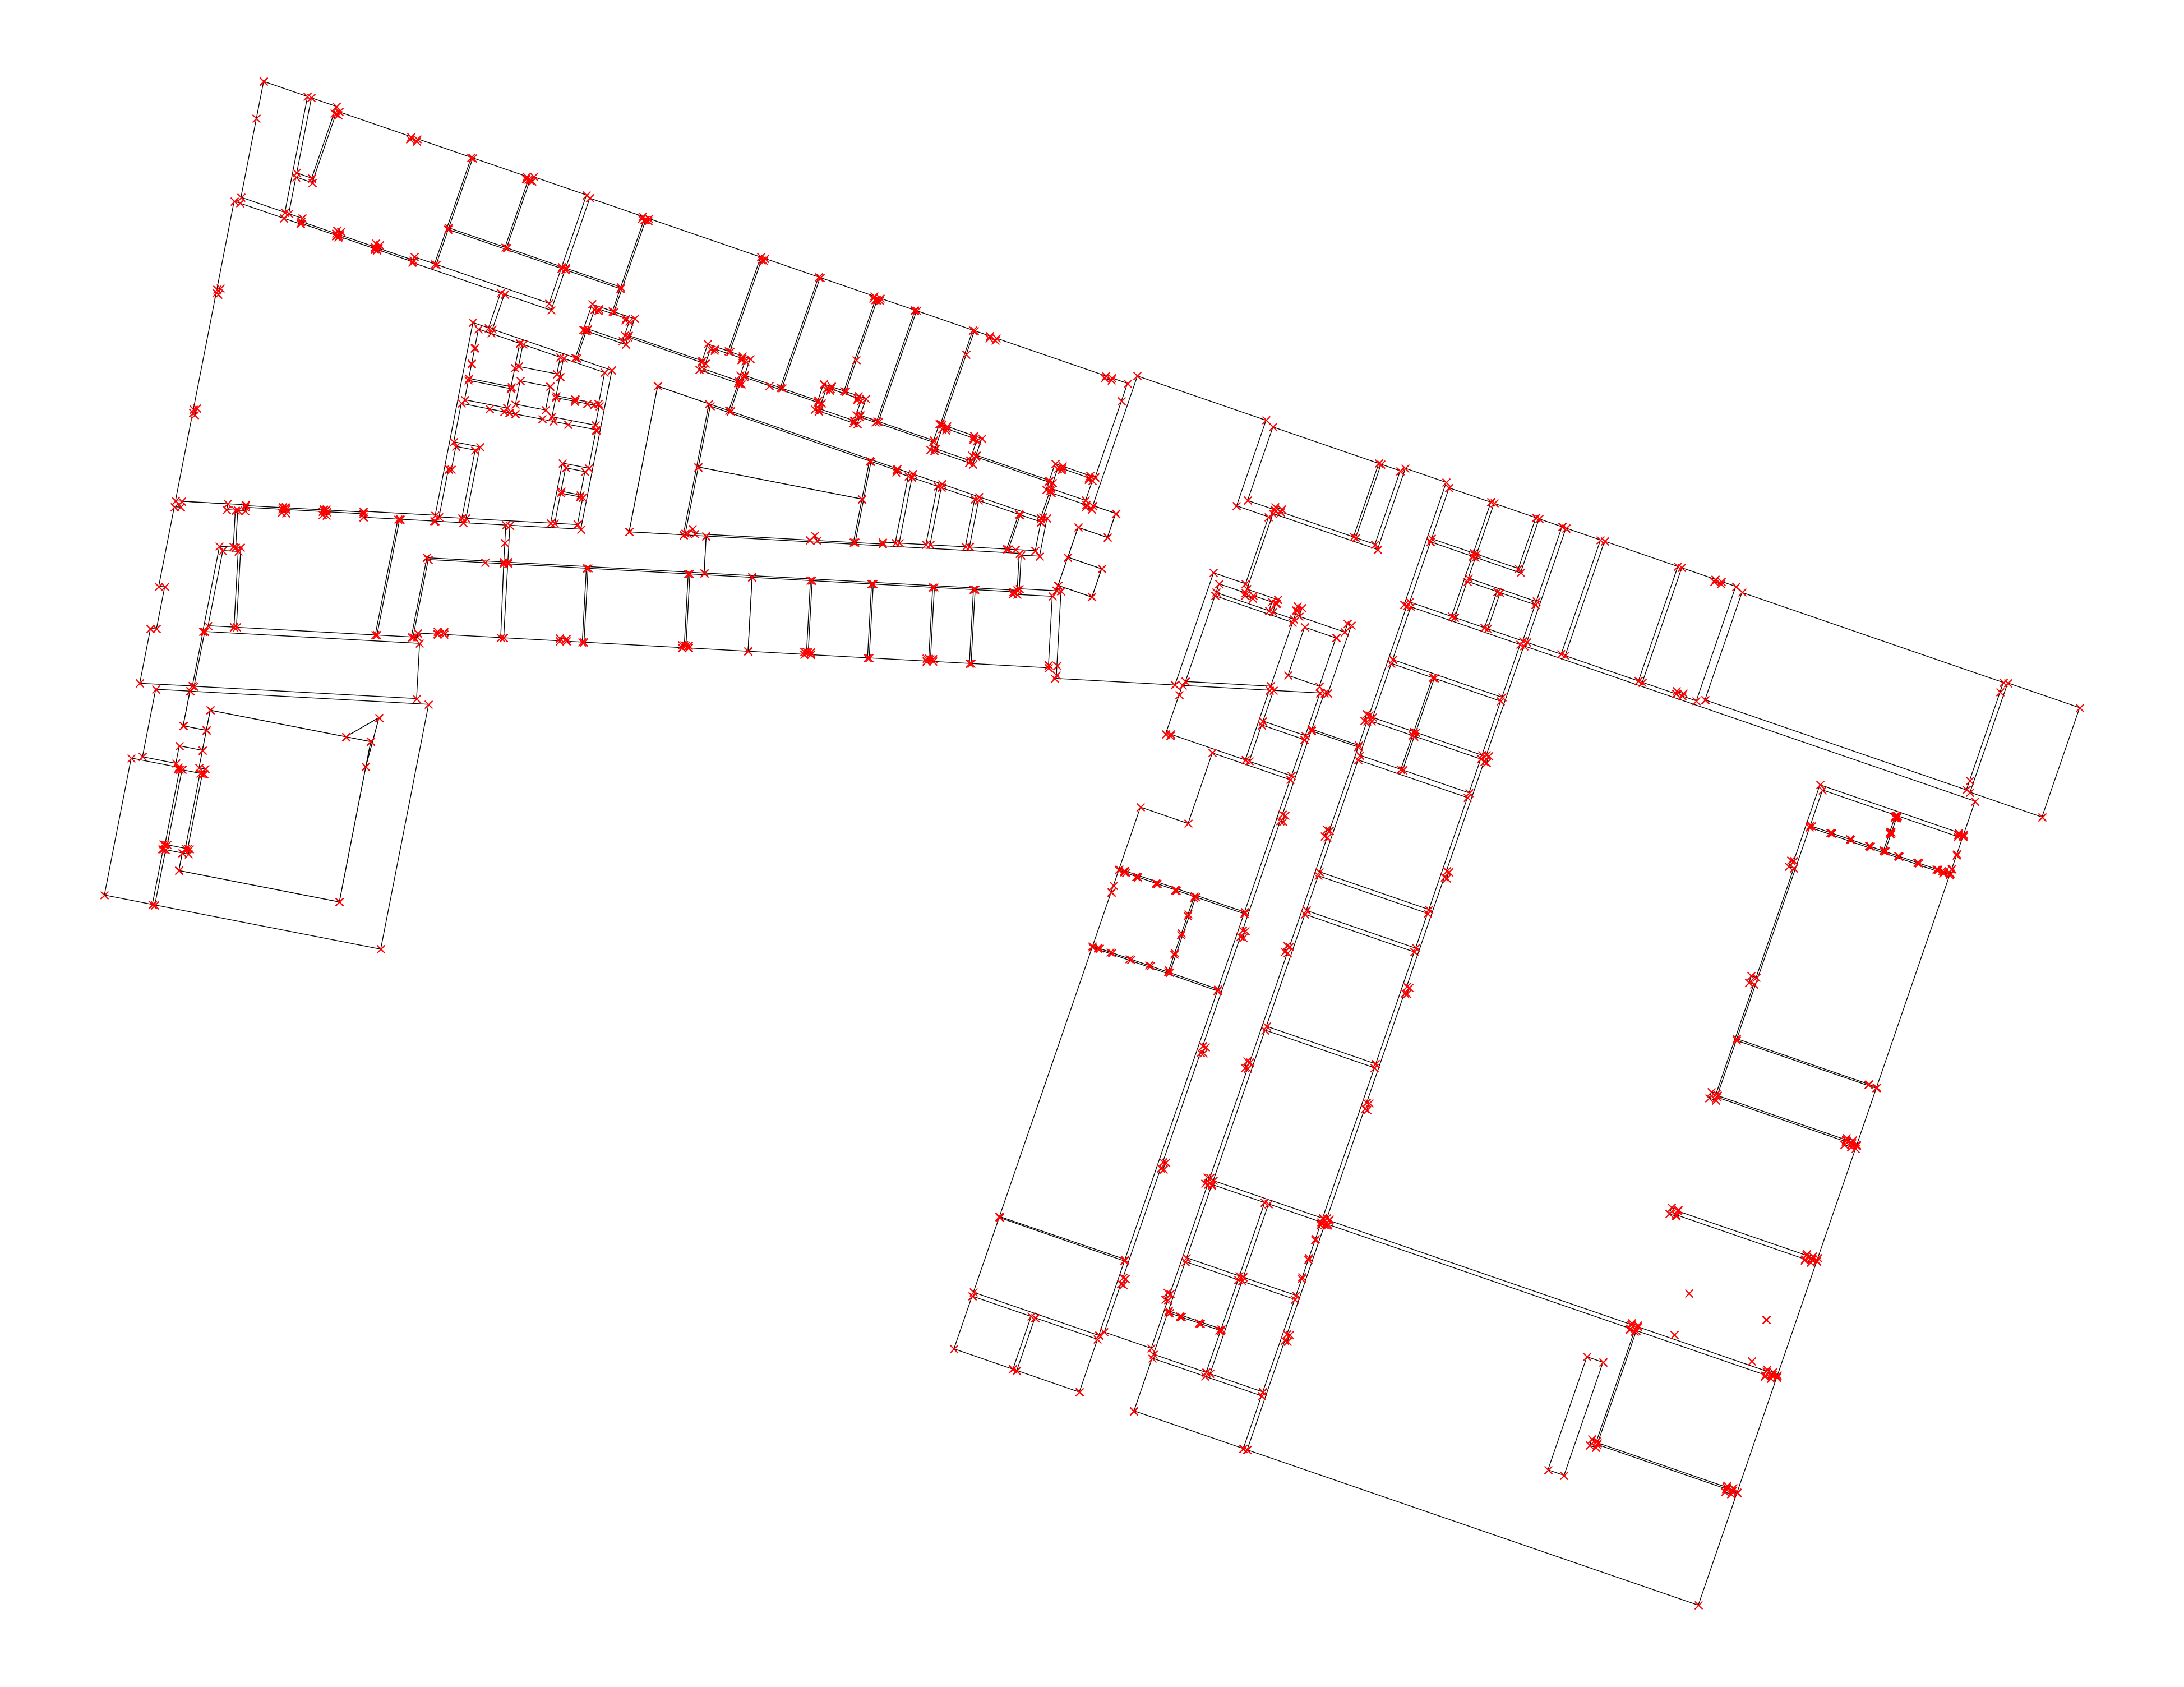

In [6]:
def visualise_points():
    ax = spaces.plot(color="white", edgecolor="black", figsize=(50, 50))
    ax.set_axis_off()
    gs = []
    for geom in spaces["geometry"]:
        for x, y in zip(*geom.exterior.coords.xy):
            point = shapely.Point(x, y)
            gs.append(point)
    gpd.GeoSeries(gs).plot(ax=ax, marker="x", color="red", markersize=100)


visualise_points()

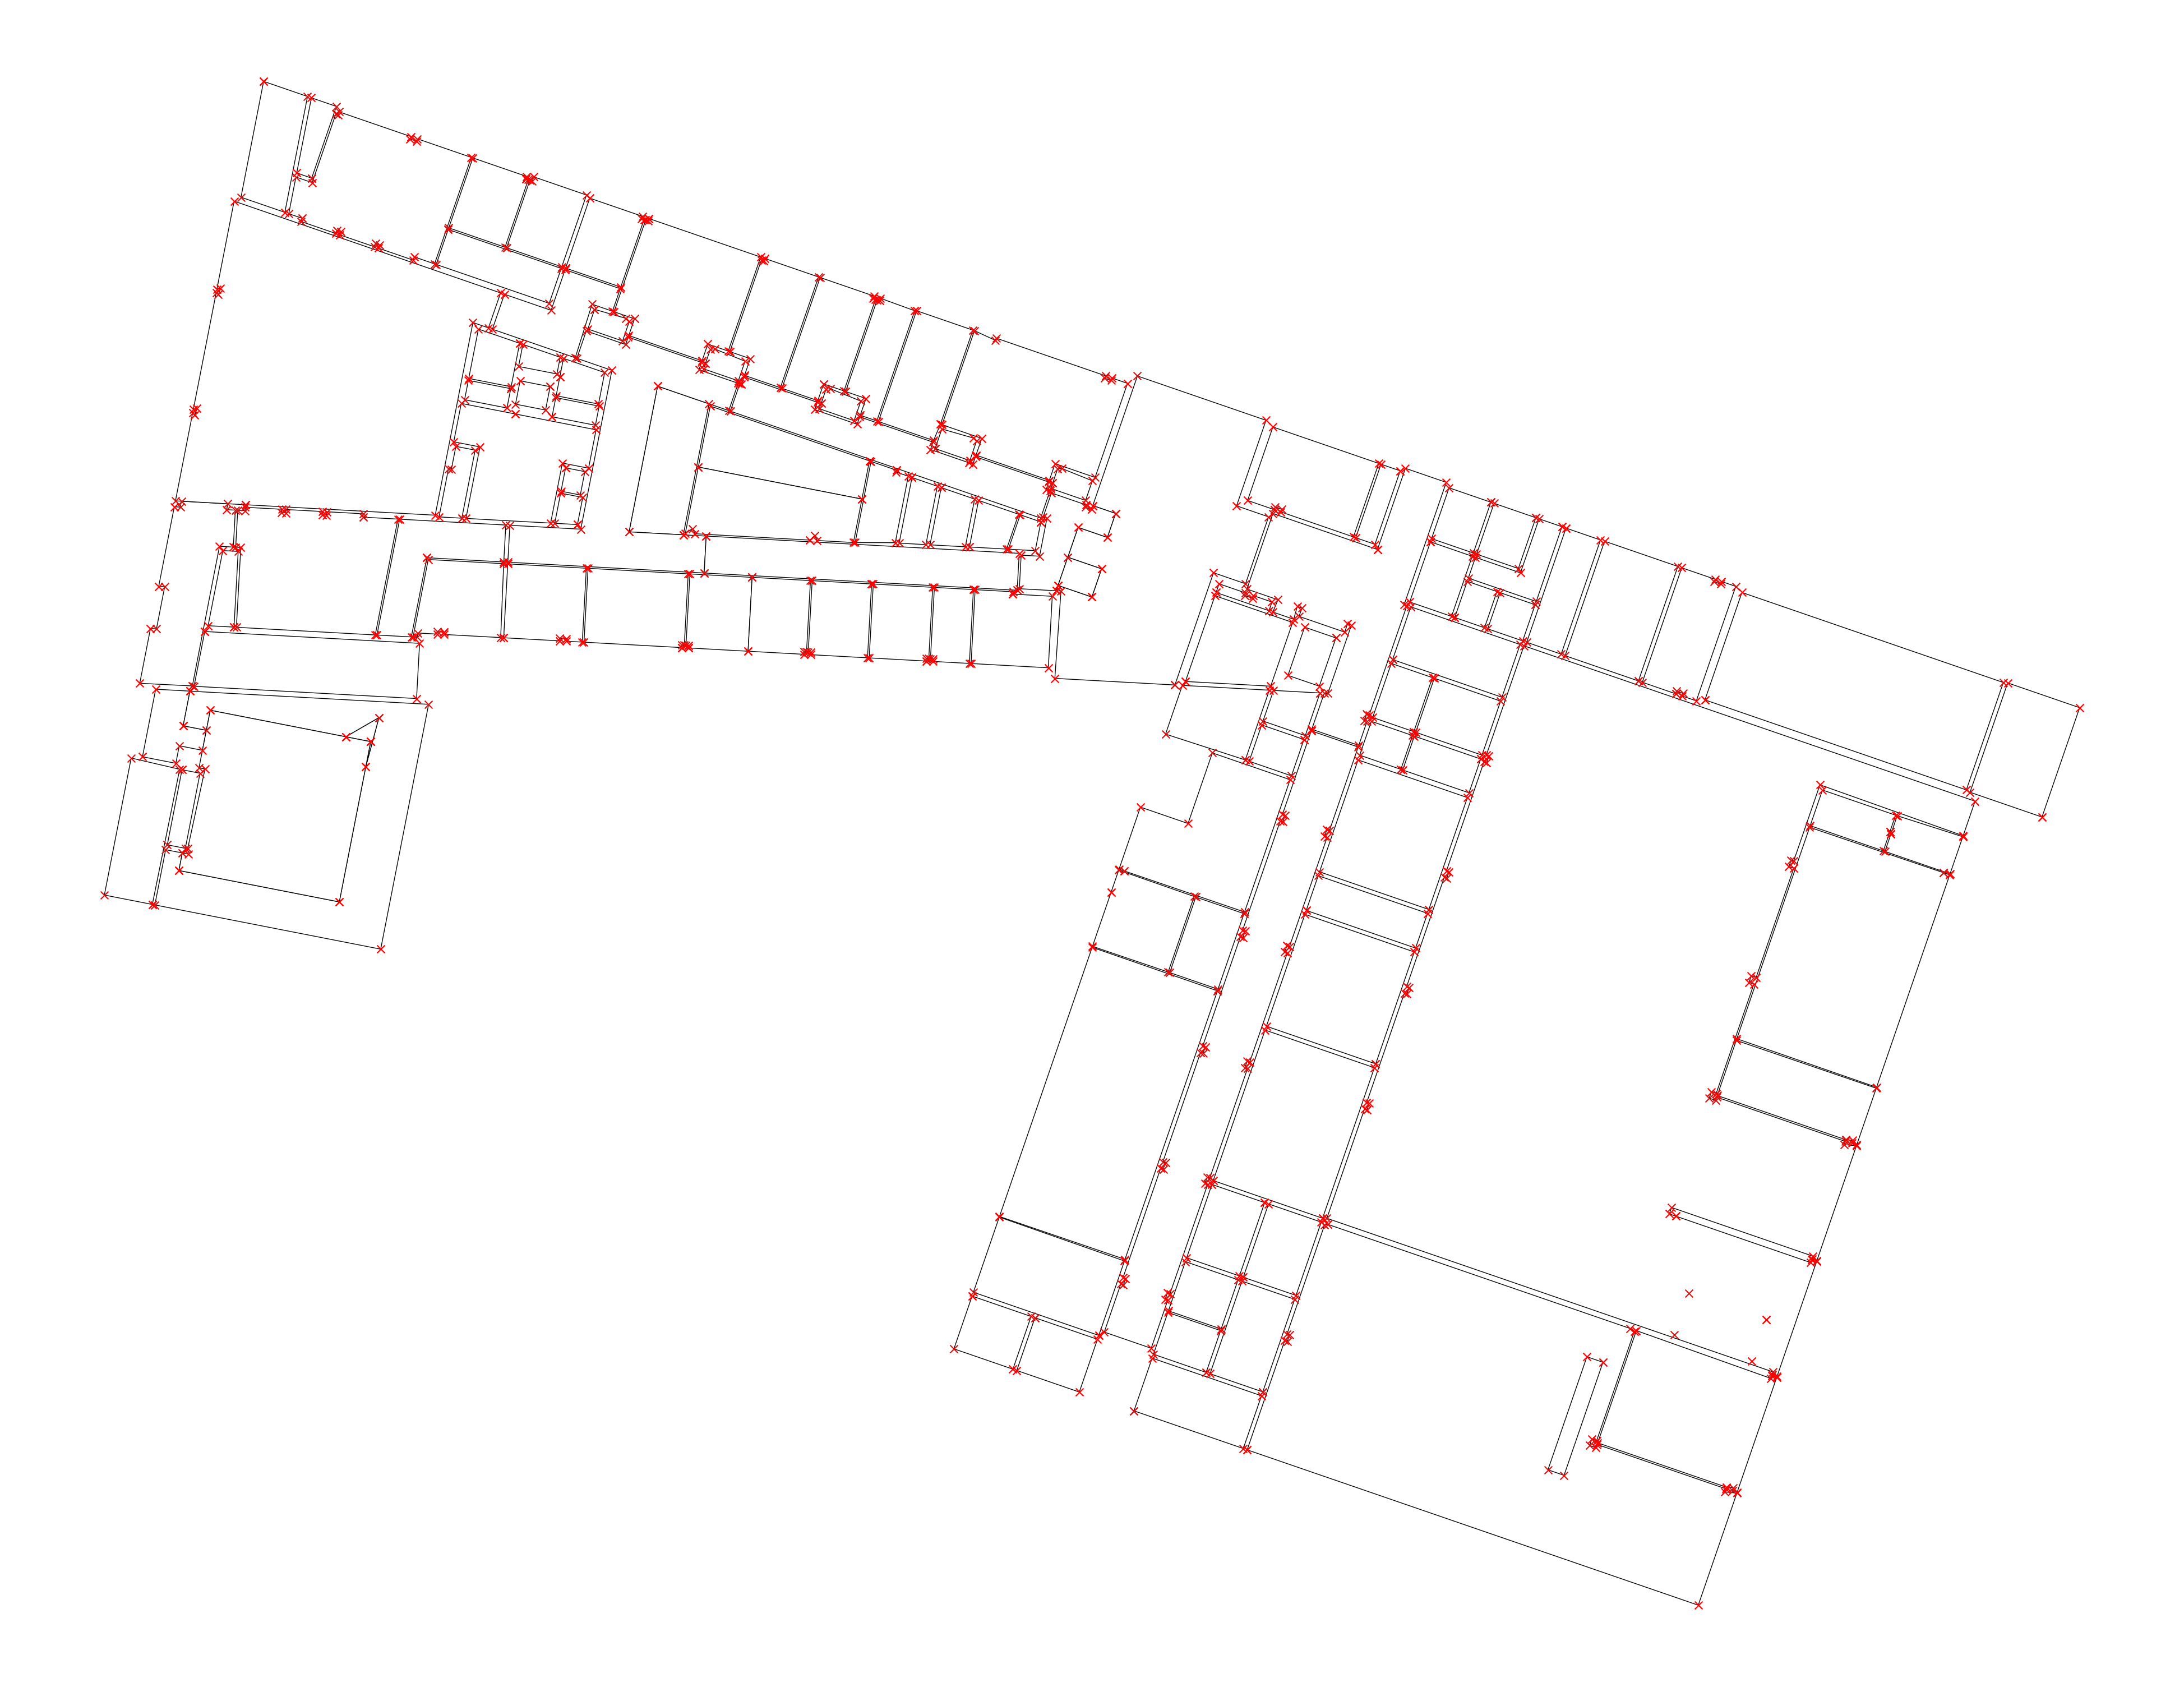

In [7]:
def simplify_shapes():
    geom = []
    for i, g in enumerate(spaces["geometry"]):
        geom.append(shapely.simplify(g, tolerance=0.1))
    spaces["geometry"] = geom


simplify_shapes()

visualise_points()

<Axes: >

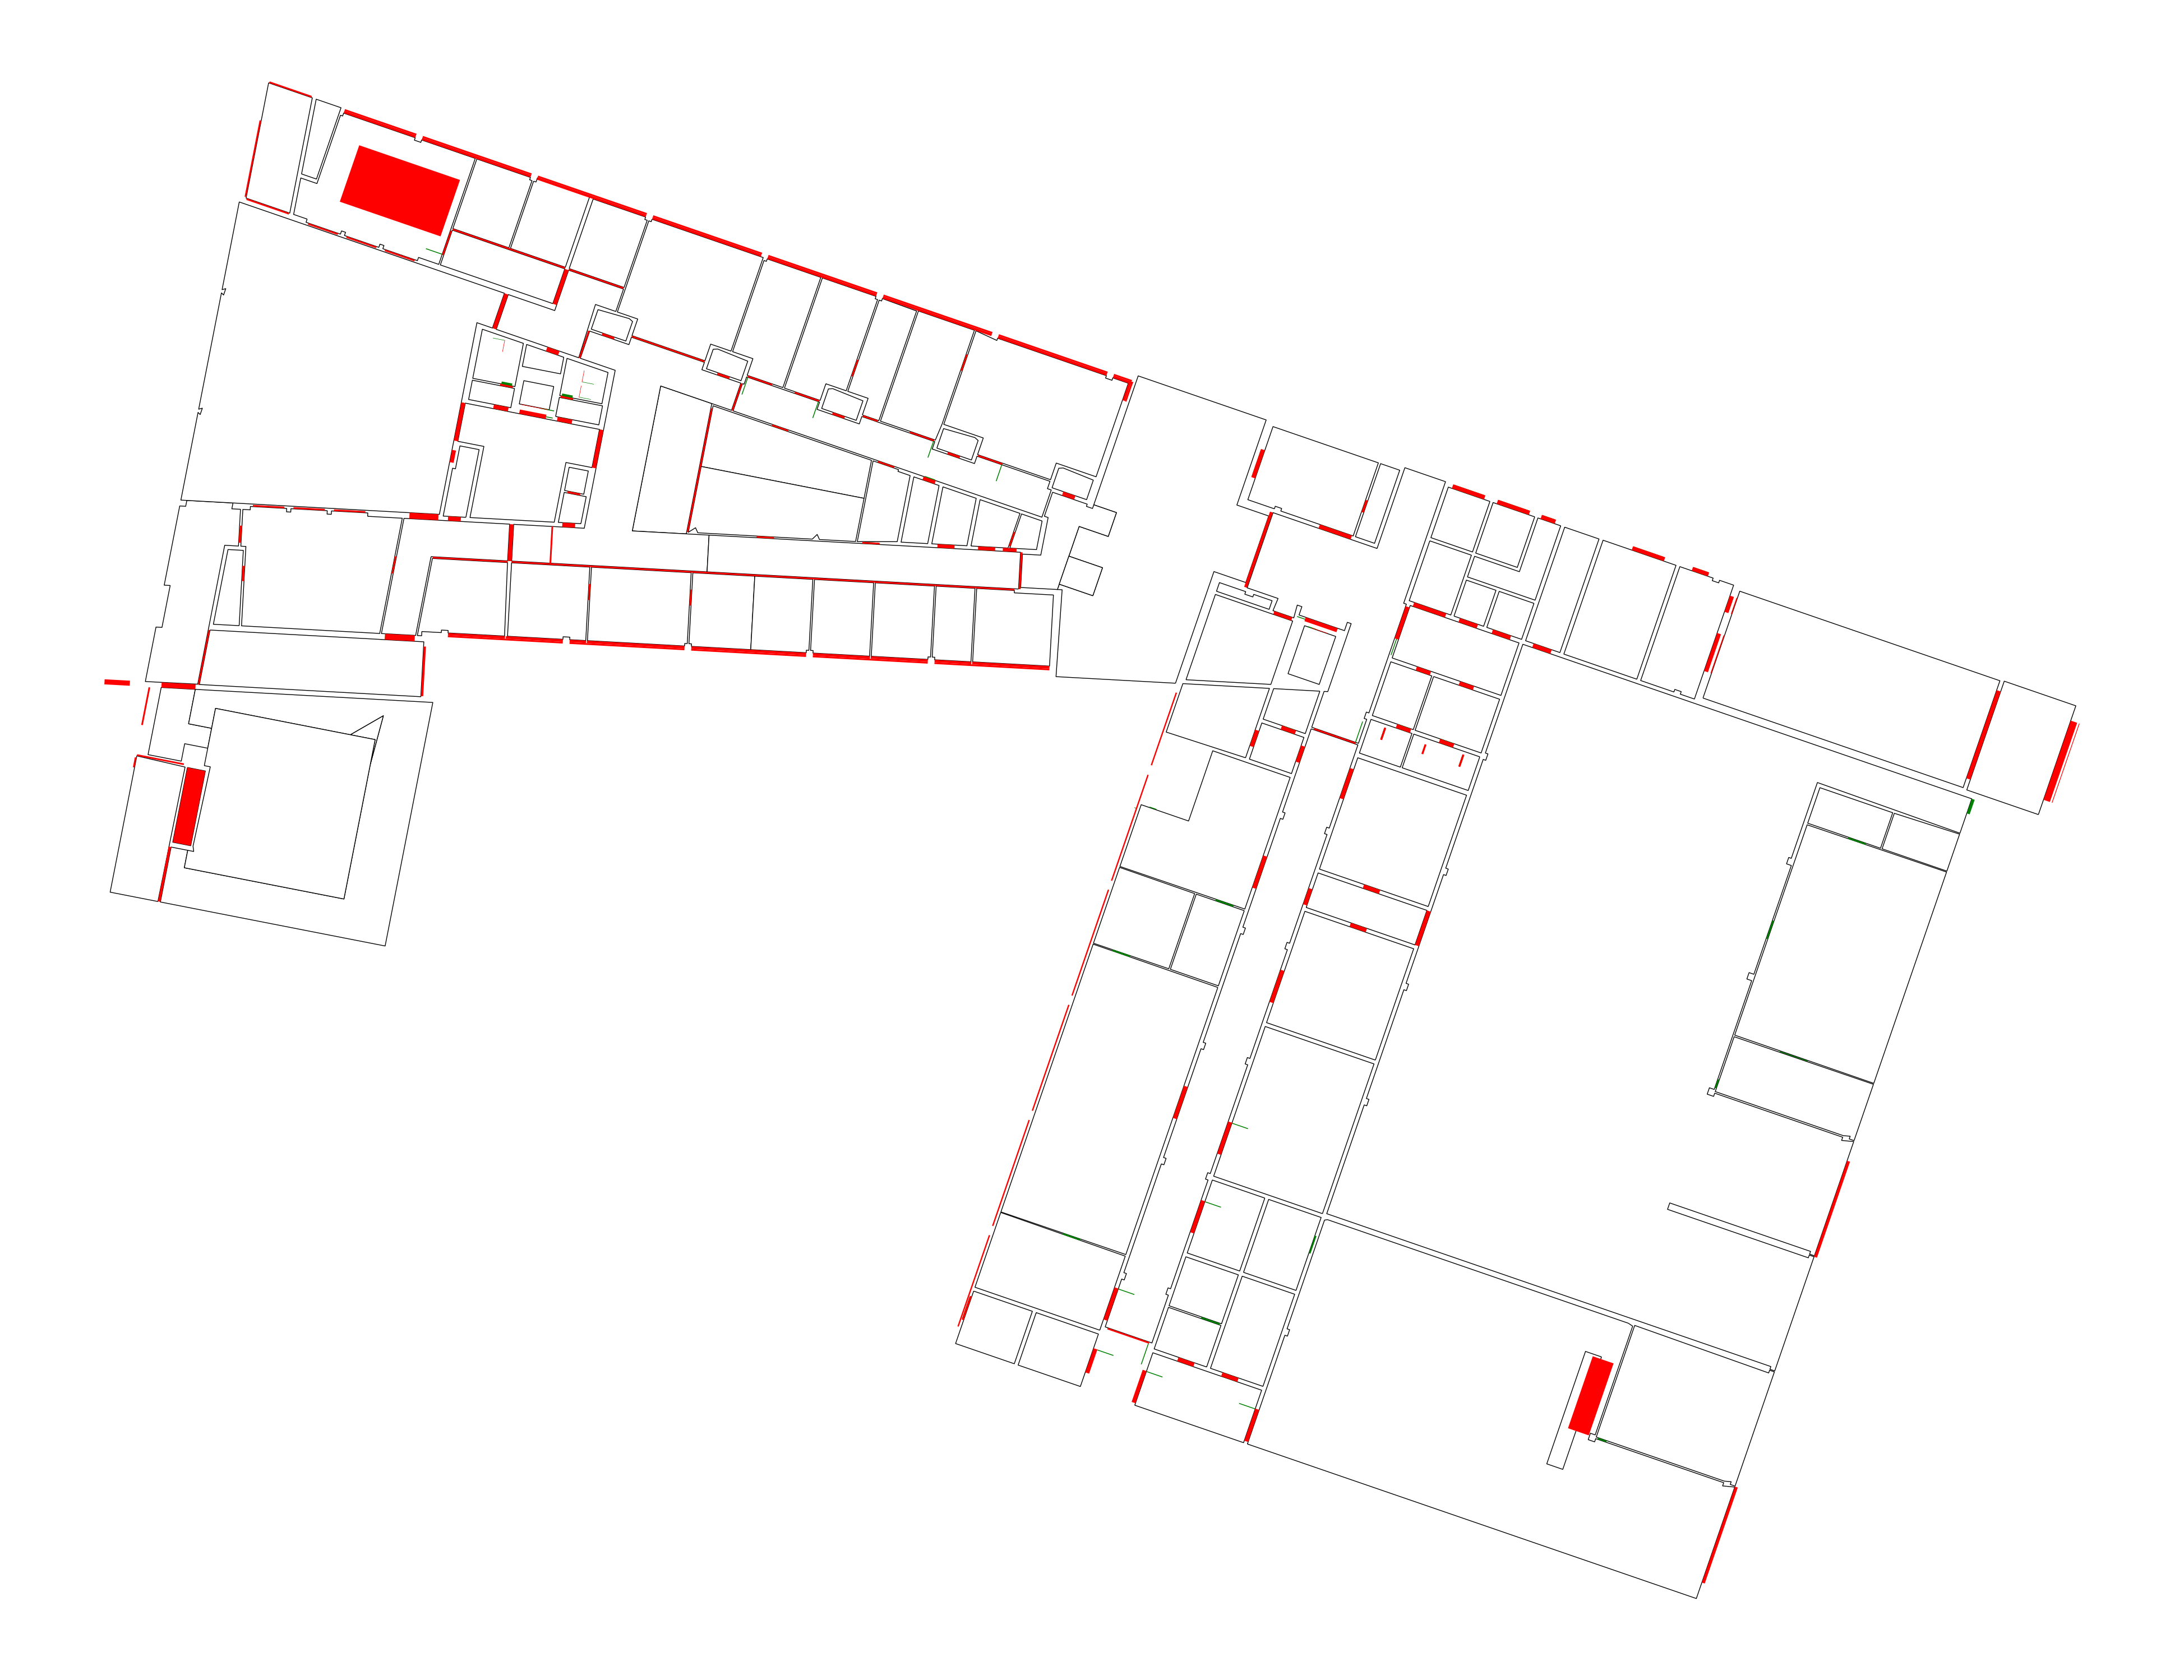

In [8]:
ax = spaces.plot(color="white", edgecolor="black", figsize=(50, 50))
ax.set_axis_off()
doors.plot(ax=ax, marker="x", color="green", markersize=100)
openings.plot(ax=ax, marker="x", color="red", markersize=100)

In [9]:
doors["width_geom"] = doors["geometry"].minimum_bounding_circle().area.map(lambda a: 2 * math.sqrt(a / math.pi))
# ø = 2 · √(A / π)
doors["geometry"] = doors["geometry"].centroid
doors.drop("type", axis=1, inplace=True)
doors

,name,metadata,height,geometry,level,indoor,width_geom
0,DOOR | Drehflügel 1-flg.(1),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",2.2,POINT (76533.291 77349.495),0,door,0.688578
1,DOOR | Drehflügel 1-flg.(2),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",2.2,POINT (76526.537 77349.867),0,door,0.688578
2,DOOR | Drehflügel 1-flg.(3),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",2.2,POINT (76532.347 77359.785),0,door,0.688578
3,DOOR | Drehflügel 1-flg.(4),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",1.8,POINT (76535.623 77360.666),0,door,0.653029
4,DOOR | Drehflügel 1-flg.(5),"{'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...",1.8,POINT (76542.43 77358.323),0,door,0.653029
...,...,...,...,...,...,...,...
120,DOORWINDOWASSEMBLY | TFK Skizze(12),"{'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...",NaN,POINT (76563.004 77307.432),0,door,1.100989
121,DOORWINDOWASSEMBLY | TFK Skizze(13),"{'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...",NaN,POINT (76565.949 77324.186),0,door,1.100989
122,DOORWINDOWASSEMBLY | TFK Skizze(14),"{'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...",NaN,POINT (76572.05 77327.161),0,door,1.100989
123,DOORWINDOWASSEMBLY | TFK Skizze(16),"{'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...",NaN,POINT (76567.818 77332.764),0,door,0.426557


In [10]:
spaces.drop(["type", "super_type", "sub_type_id", "sub_type"], axis=1, inplace=True)
spaces

KeyError: "['super_type', 'sub_type_id', 'sub_type'] not found in axis"

In [ ]:
visualise_points()

In [ ]:
for k, v in doors.metadata.iloc[0].items():
    print(k.rjust(50), v)

In [ ]:
# is this door hinged?
doors["door"] = doors.metadata.map(lambda m: m.get("PanelOperation"))
doors["door"] = doors["door"].map(lambda d: {"SWINGING": "hinged", None: "yes"}[d])
doors.door = doors.door.astype("category")

In [ ]:
def try_to_float(f: str | None) -> float | None:
    if f is None:
        return None
    try:
        return float(f)
    except ValueError:
        print(f"Could not convert '{f}' to float")
        return None


# geometry according to metadata
doors["height_meta"] = doors.metadata.map(lambda m: try_to_float(m.get("Türen.Höhe")))
doors["width_meta"] = doors.metadata.map(lambda m: try_to_float(m.get("Türen.Breite")))

In [ ]:
for dimension in ["height", "width"]:
    dimension_known = (doors[f"{dimension}_meta"] - doors[f"{dimension}_geom"]).abs() < 0.4
    doors[dimension] = doors[f"{dimension}_meta"]
    doors[dimension] = doors[dimension].where(dimension_known)
    doors.drop([f"{dimension}_meta", f"{dimension}_geom"], inplace=True, axis=1)

In [ ]:
doors.drop(["super_type", "sub_type_id"], inplace=True, axis=1)

In [ ]:
spaces.metadata

In [ ]:
for k, v in spaces.metadata.iloc[0].items():
    print(k.rjust(50), v)

    """

    Raum.Projekt.Geschoßbezeichnung None
    Raum.Projekt.Geschoßhöhe None
    Raum.Projekt.Geschoßniveau None

   Raum.Nummer 0533B
    Raum.RaumNR -0533B
    Raum.FM.Raum.ID 02-55-5505-100-533B

    Türen None
    Türen.FM None
    Türen.SAP None
    Türstil None"""

In [ ]:
spaces["height_meta"] = spaces.metadata.map(lambda m: try_to_float(m.get("Raum.Lichte.Raumhöhe")))
spaces["height_meta2"] = spaces.metadata.map(lambda m: try_to_float(m.get("Raum.Gesamt.Raumhöhe")))
spaces["height_meta3"] = spaces.metadata.map(lambda m: try_to_float(m.get("ADT_Pset_Space.CeilingHeight")))

In [ ]:
dimension_known = (spaces["height_meta"] - spaces["height_geom"]).abs() < 2.0
dimension_known &= (spaces["height_meta"] - spaces["height_meta2"]).abs() < 2.0
dimension_known &= (spaces["height_meta"] - spaces["height_meta3"]).abs() < 2.0

spaces["height"] = spaces["height_meta"]
spaces["height"] = spaces["height"].where(dimension_known)
spaces.drop(["height_meta", "height_meta2", "height_meta3", "height_geom"], inplace=True, axis=1)

In [ ]:
spaces["ref"] = spaces.metadata.map(lambda m: m.get("Raum.Nummer"))
spaces["ref2"] = spaces.metadata.map(lambda m: m.get("Raum.RaumNR"))

RAUM_TO_SAP_LEVEL_LUT = {"100": "EG", "090": "U1"}


def to_tum_sap_raum_id(m: str | None) -> str | None:
    """02-55-5505-100-533B  -> 5505.EG.533B"""
    if m is None:
        return None
    r_parts = m.split("-")
    r_parts = r_parts[2:]
    if r_parts[1] not in RAUM_TO_SAP_LEVEL_LUT:
        raise ValueError(
            f"{r_parts[1]} (in room name {m}) is not a valid raum level. Please update RAUM_TO_SAP_LEVEL_LUT"
        )
    r_parts[1] = RAUM_TO_SAP_LEVEL_LUT[r_parts[1]]
    return ".".join(r_parts)


spaces["ref:tum"] = spaces.metadata.map(lambda m: to_tum_sap_raum_id(m.get("Raum.FM.Raum.ID")))

In [ ]:
spaces["name_meta1"] = spaces.metadata.map(lambda m: m.get("Raum.Name"))
spaces["name_meta2"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Lang"))
spaces["name_meta3"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Z1"))
spaces["name_meta4"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Z2"))
spaces["name_meta5"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Z3"))

In [ ]:
def any_name_eq(comp: str) -> gpd.GeoSeries:
    return (
        (spaces["name_meta1"] == comp)
        | (spaces["name_meta2"] == comp)
        | (spaces["name_meta3"] == comp)
        | (spaces["name_meta4"] == comp)
        | (spaces["name_meta5"] == comp)
    )


def any_name_like(comp: str) -> gpd.GeoSeries:
    return (
        spaces["name_meta1"].map(lambda n: n is not None and comp in n)
        | spaces["name_meta2"].map(lambda n: n is not None and comp in n)
        | spaces["name_meta3"].map(lambda n: n is not None and comp in n)
        | spaces["name_meta4"].map(lambda n: n is not None and comp in n)
        | spaces["name_meta5"].map(lambda n: n is not None and comp in n)
    )


is_corridor = any_name_eq("Flur") | any_name_like("Flure")
is_luft = any_name_eq("Luftflächen") | any_name_eq("Straße") | any_name_eq("Fahrzeugverkehrsfläche")
is_elevator = any_name_eq("Personenaufzug") | any_name_like("Hebebühne")
is_stair = any_name_eq("Treppenhaus") | any_name_eq("Treppe")

# sanity check: not-luft => ref2 is ref, but with a minus...
assert (is_luft | (spaces["ref"].map(lambda r: "-" + r if r else None) == spaces["ref2"])).all()
spaces.drop(["ref2"], inplace=True, axis=1)

spaces.drop(["name_meta1", "name_meta2", "name_meta3", "name_meta4", "name_meta5"], inplace=True, axis=1)

In [ ]:
spaces["room"] = is_elevator.map(lambda b: "elevator" if b else None)
spaces.loc[is_stair, "room"] = "stairs"
spaces.loc[is_corridor, "indoor"] = "corridor"
spaces = spaces[~is_luft].copy(deep=True)

In [ ]:
# final dropping of random junk
spaces.drop(["metadata"], inplace=True, axis=1)
doors.drop(["metadata", "sub_type"], inplace=True, axis=1)

In [ ]:
df = gpd.GeoDataFrame(pd.concat([spaces, doors], ignore_index=True))
out = filename.replace(".parquet", ".geojson")
df_json: str = df.to_json(na="drop", drop_id=True, to_wgs84=True)
with open(out, "w") as f:
    f.write(df_json)

In [ ]:
filename

In [ ]:
doors